<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Projeto Pipeline de Dados do Telegram - Parte 2**

---

Este projeto consiste em construir um *pipeline* de dados que irá ingerir, processar, armazenar e expor mensagens de um grupo do **Telegram** para que posteriormente seja possível realizar algumas análises tendo como base o histórico dessas mensagens.


Feito por: [Taíta B. Ramos](https://www.linkedin.com/in/ta%C3%ADta-b-ramos-4448ba121/)

# **Tópicos**

<ol type="1">
  <li>Contexto;</li>
  <li>Sistema Transacional: Telegram;</li>
  <li>Sistema Analítico - Ingestão;</li>
  <li>Sistema Analítico - ETL;</li>
  <li>Apresentação;</li>
</ol>

---

# 1\. **Contexto**

### **1.1. O que é um Pipeline de Dados?**

Um **pipeline de dados** é basicamente um conjunto de etapas que transforma dados brutos em informações úteis para análise. As empresas lidam com uma enxurrada de dados vindos de vários lugares — apps, dispositivos IoT, redes digitais... é dado pra todo lado. Mas esses dados, do jeito que chegam, não servem pra muita coisa. Antes de virarem insights, eles precisam ser organizados: movidos, filtrados, formatados e analisados.
É aí que entra o pipeline: ele conecta várias tecnologias que ajudam a validar os dados, resumir o que importa e identificar padrões que podem orientar decisões estratégicas. Quando bem estruturado, esse processo dá suporte a projetos de big data, como visualizações interativas, análises exploratórias e até aplicações de machine learning.

### **1.2. Chatbot**

Um **chatbot** é um tipo de software que interage com usuários através de conversas automatizadas em plataformas de mensagens. Uma aplicação comum de **chatbots** é o seu uso no atendimento ao cliente, onde, de maneira geral, ajudam clientes a resolver problemas ou esclarecer dúvidas recorrentes antes mesmo que um atendente humano seja acionado.

### **1.3. Telegram**

**Telegram** é uma plataforma de mensagens instantâneas *freeware* (distribuído gratuitamente) e, em sua maioria, *open source*. É muito popular entre desenvolvedores por ser pioneiro na implantação da funcionalidade de criação de **chatbots**, que, por sua vez, permitem a criação de diversas automações.

### **1.4. Arquitetura**

A arquitetura proposta é dividida em duas:
- Transacional: onde os dados são produzidos, no **Telegram**;
- Analítica: onde os dados são analisados, na Amazon Web Services (AWS).

A figura abaixo ilustra essa arquitetura:

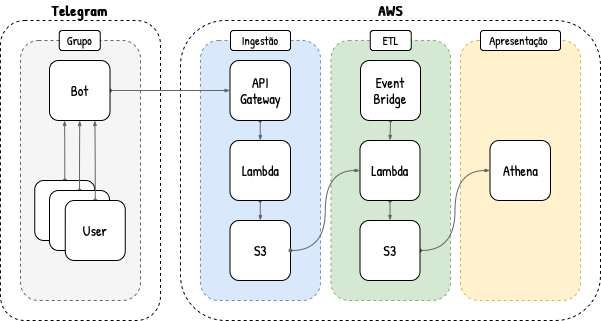

- **Telegram**:

 O `Telegram` representa a fonte de dados transacionais. Mensagens enviadas por usuários em um grupo são capturadas por um *bot* e redirecionadas via *webhook* do *backend* do aplicativo para um *endpoint* (endereço *web* que aceita requisições HTTP) exposto pelo `AWS API Gateway`. As mensagens trafegam no corpo ou *payload* da requisição.



- **AWS | Ingestão**:

Uma requisição HTTP com o conteúdo da mensagem em seu *payload* é recebia pelo `AWS API Gateway` que, por sua vez, as redireciona para o `AWS Lambda`, servindo assim como seu gatilho. Já o `AWS Lambda` recebe o *payload* da requisição em seu parâmetro *event*, salva o conteúdo em um arquivo no formato JSON (original, mesmo que o *payload*) e o armazena no `AWS S3` particionado por dia.



- **AWS | ETL**:

Uma vez ao dia, o `AWS Event Bridge` aciona o `AWS Lambda` que processa todas as mensagens do dia anterior (atraso de um dia ou D-1), denormaliza o dado semi-estruturado típico de arquivos no formato JSON, salva o conteúdo processado em um arquivo no formato Apache Parquet e o armazena no `AWS S3` particionado por dia.



- **AWS | Apresentação**:

Por fim, uma tabela do `AWS Athena` é apontada para o *bucket* do `AWS S3` que armazena o dado processado: denormalizado, particionado e orientado a coluna. Profissionais de dados podem então executar consultas analíticas (agregações, ordenações, etc.) na tabela utilizando o SQL para a extração de *insights*.

# **2. Sistema Transacional: Telegram**

O **Telegram** representa a fonte transacional de dados do nosso *pipeline* de dados. Nesta etapa, será criado um grupo e um **bot**. O **bot** será adicionado ao grupo como adminstrador e captará **todas** as mensagens enviadas. A opção de adicionar o *bot* a novos grupos será desabilitada e as mensagens que surgirem no grupo serão acessadas através da API (*application programming interface*) de *bots* dos **Telegram** (documentação neste [link](https://core.telegram.org/bots/api)).

Grupo e bot criado:

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Telegram%20grupo.png" width="250"/>

  <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Telegram%20bot.png" width="250"/>

Bot incluído no grupo, como administrador, e algumas messagens:

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Mensagens%20e%20integrantes%20do%20grupo%20telegram.png" width="900"/>



# **2. Sistema Analítico - Ingestão**

A etapa de **ingestão** é responsável, como seu o próprio nome diz, pela ingestão dos dados transacionais em ambientes analíticos. De maneira geral, o dado ingerido é persistido no formato mais próximo do original, ou seja, nenhuma transformação é realizada em seu conteúdo ou estrutura (*schema*). Como exemplo, dados de uma API *web* que segue o formato REST (*representational state transfer*) são entregues, logo, persistidos, no formato JSON.

> Persistir os dados em seu formato original trás muitas vantagens, como a possibilidade de reprocessamento.

Pode ser conduzida de duas formas:

 - **Batch**: blocos de dados são ingeridos em uma frequência bem definida, geralmente na escala de horas ou dias;
 - **Streaming**: dados são ingeridos conforme são produzidos e disponibilizados.

Na parte 1 deste projeto, usamos a abordagem conhecida como polling (interrogamento), onde as mensagens capturadas pelo *bot* Telegram são ingeridas através da API *web* de *bots* do **Telegram**, no formato JSON, mas neste caso, temos o risco de perda de mensagens pois o Telegram só as mantém por 24 horas.
Diante disso, seria mais indicado a ingestão via **streaming** com Webhook (gancho *web*), onde o *webhook*  redireciona as mensagens automaticamente para outra API *web* definida.

Sendo assim, precisamos de um serviço da AWS que forneça um API *web* para receber os dados redirecionados, o `AWS API Gateway` (documentação neste [link](https://docs.aws.amazon.com/pt_br/apigateway/latest/developerguide/welcome.html)). Dentre suas diversas funcionalidades, o `AWS API Gateway` permite o redirecionamento do dado recebido para outros serviços da AWS. Logo, vamos conectá-lo ao `AWS Lambda`, que pode sua vez, irá armazenar o dado em seu formato original (JSON) em um *bucket* do `AWS S3`.

> Sistemas que reagem a eventos são conhecidos como *event-driven*.

### **2.1. AWS S3**

Na etapa de **ingestão**, o `AWS S3` tem a função de passivamente armazenar as mensagens captadas pelo *bot* do **Telegram** no seu formato original: JSON. Para tanto, basta a criação de um *bucket*. Como padrão, esse bucket recebe o sufixo `-raw` em seu nome.

> **Nota**: um `data lake` é o nome dado a um repositório de um grande volume dados. É organizado em zonas que armazenam replicadas dos dados em diferentes níveis de processamento. A nomenclatura das zonas varia, contudo, as mais comuns são: *raw* e *enriched* ou *bronze*, *silver* e *gold*.

O Bucket raw criado foi: bucket-tatabr-ebac-pipetelegram-raw

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Bucket_raw.png" width="900"/>



### **2.2. AWS Lambda**

Na etapa de **ingestão**, o `AWS Lambda` tem a função de ativamente persistir as mensagens captadas pelo *bot* do **Telegram** em um *bucket* do `AWS S3`. Para tanto vamos criar uma função que opera da seguinte forma:

 - Recebe a mensagem no parâmetro `event`;
 - Verifica se a mensagem tem origem no grupo do **Telegram** correto;
 - Persiste a mensagem no formato JSON no *bucket* do `AWS S3`;
 - Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de *bots* do **Telegram**.

> **Nota**: No **Telegram**, restringimos a opção de adicionar o *bot* a grupos, contudo, ainda é possível iniciar uma conversa em um *chat* privado.

A Função Lambda raw criada foi: func-tatabr-ebac-pipetelegram-raw

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Função_lambda_raw.png" width="900"/>

O código da função LAMBDA:

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone
import boto3

logger = logging.getLogger()
logger.setLevel(logging.INFO)

def lambda_handler(event: dict, context: dict) -> dict:
    BUCKET = os.environ.get('AWS_S3_BUCKET')
    TELEGRAM_CHAT_ID = int(os.environ.get('TELEGRAM_CHAT_ID'))

    tzinfo = timezone(offset=timedelta(hours=-3))
    date = datetime.now(tzinfo).strftime('%Y-%m-%d')
    timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')
    filename = f'{timestamp}.json'

    s3 = boto3.client('s3')

    try:
        logger.info(f"Evento recebido: {json.dumps(event)}")

        chat_id = event.get("message", {}).get("chat", {}).get("id")
        if chat_id != TELEGRAM_CHAT_ID:
            logger.info(f"Mensagem ignorada: chat_id {chat_id} diferente do esperado {TELEGRAM_CHAT_ID}")
            return dict(statusCode="200")

        temp_path = f"/tmp/{filename}"
        with open(temp_path, mode='w', encoding='utf8') as fp:
            json.dump(event, fp)

        s3_key = f'telegram/context_date={date}/{filename}'
        s3.upload_file(temp_path, BUCKET, s3_key)

        logger.info(f"Mensagem salva com sucesso em {s3_key}")
        return dict(statusCode="200")

    except Exception as exc:
        logger.error(f"Erro ao processar mensagem: {str(exc)}")
        return dict(statusCode="500", body=json.dumps({"error": str(exc)}))

Para que a função funcione corretamente, foram realilzadas algumas outras configurações:

 - **Definição das Variáveis de ambiente**

Note que o código exige a configuração de duas variáveis de ambiente: `AWS_S3_BUCKET` com o nome do *bucket* do `AWS S3` e `TELEGRAM_CHAT_ID` com o id do *chat* do grupo do **Telegram**.

> **Nota**: Variáveis de ambiente são excelentes formas de armazenar informações sensíveis.

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Variáveis%20de%20Ambiente.png" width="800"/>

 - **Definir Permissão**

Por fim, foi adicionado permissão de escrita no *bucket* do `AWS S3` para a função do `AWS Lambda` no `AWS IAM`.

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Permissão_S3_Lambda_raw.png" width="800"/>

### **2.3. AWS API Gateway**

Na etapa de **ingestão**, o `AWS API Gateway` tem a função de receber as mensagens captadas pelo *bot* do **Telegram**, enviadas via *webhook*, e iniciar uma função do `AWS Lambda`, passando o conteúdo da mensagem no seu parâmetro *event*. Para tanto foi criada uma API, configurada como gatilho da função do `AWS Lambda`:

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/API_criada.png" width="800"/>

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Método%20POST.png" width="800"/>

Por fim, a API foi implementada e obtemos o seu endereço *web*:

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/API.png" width="800"/>

Após todo o processo, armazenamos a `url` gerada dentro de uma variável `aws_api_gateway_url`:

In [ ]:
from getpass import getpass
import requests

In [ ]:
aws_api_gateway_url = getpass()

··········


### **2.4. Telegram**

Configurando o *webhook* para redirecionar as mensagens para a `url` do `AWS API Gateway`.

 - **setWebhook**

O método `setWebhook` configura o redirecionamento das mensagens captadas pelo *bot* para o endereço *web* do paramametro `url`.

> **Nota**: os métodos `getUpdates` e `setWebhook` são mutualmente exclusivos, ou seja, enquanto o *webhook* estiver ativo, o método `getUpdates` não funcionará. Para desativar o *webhook*, basta utilizar o método `deleteWebhook`.

In [ ]:
from getpass import getpass
token = getpass()

··········


In [ ]:
import json
base_url = f'https://api.telegram.org/bot{token}'

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


 - **getWebhookInfo**

O método `getWebhookInfo` retorna as informações sobre o *webhook* configurado.

In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://b1blinkai8.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 0,
    "max_connections": 40,
    "ip_address": "52.67.193.193"
  }
}


## 3\. **Sistema Analítico - ETL**

A etapa de **extração, transformação e carregamento** (do inglês *extraction, transformation and load* ou **ETL**) é uma etapa abrangente responsável pela manipulação dos dados ingeridos de sistemas transacionais, ou seja, já persistidos em camadas cruas ou *raw* de sistemas analíticos. Os processos conduzidos nesta etapa variam bastante de acordo com a área da empresa, do volume/variedade/velocidade do dado consumido, etc. Contudo, em geral, o dado cru ingerido passa por um processo recorrente de *data wrangling* onde o dado é limpo, deduplicado, etc. e persistido com técnicas de particionamento, orientação a coluna e compressão. Por fim, o dado processado está pronto para ser analisado por profissionais de dados.

Neste projeto, as mensagens de um único dia, persistidas na camada cru, serão compactas em um único arquivo, orientado a coluna e comprimido, que será persistido em uma camada enriquecida. Além disso, durante este processo, o dado também passará por etapas de *data wrangling*.

Para isso, utilizamos uma função do `AWS Lambda` como motor de processamento e um *bucket* do `AWS S3` como camada enriquecida para a persistência do dado processado. Para garantir a recorrência, configuramos uma regra do `AWS Event Bridge` como gatilho diáro da função.

### **3.1. AWS S3**

Na etapa de **ETL**, o `AWS S3` tem a função de passivamente armazenar as mensagens processadas de um dia em um único arquivo no formato Parquet. Para tanto, basta a criação de um *bucket*. Como padrão, adicionamos o sufixo `-enriched` ao seu nome.

-> bucket-tatabr-ebac-pipetelegram-enriched

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Bucket_enriched.png" width="800"/>

> **Nota**: um `data lake` é o nome dado a um repositório de um grande volume dados. É organizado em zonas que armazenam replicadas dos dados em diferentes níveis de processamento. A nomenclatura das zonas varia, contudo, as mais comuns são: *raw* e *enriched* ou *bronze*, *silver* e *gold*.

### **3.2. AWS Lambda**

Na etapa de **ETL**, o `AWS Lambda` tem a função de ativamente processar as mensagens captadas pelo *bot* do **Telegram**, persistidas na camada cru no *bucket* do `AWS S3`, e persisti-las na camada enriquecida, também em um *bucket* do `AWS S3`. Logo, vamos criar uma função que opera da seguinte forma:

-> func-tatabr-ebac-pipetelegram-enriched

 - Lista todos os arquivos JSON de uma única participação da camada crua de um *bucket* do `AWS S3`;
 - Para cada arquivo listado:
  - Faz o *download* do arquivo e carrega o conteúdo da mensagem;
  - Executa uma função de *data wrangling*;
  - Cria uma tabela do PyArrow e a contatena com as demais.
 - Persiste a tabela no formato Parquet na camada enriquecida em um *bucket* do `AWS S3`.

> **Nota**: O fato de utilizarmos duas camadas de armazenamento e processamento, permite que possamos reprocessar os dados crus de diversas maneiras, quantas vezes forem preciso.

> **Nota**: A função processa as mensagens do dia anterior (D-1).

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Função_lambda_enriched.png" width="800"/>

O código da função:

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

O código da função de *data wrangling*:

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

Para que a função funcione corretamente, algumas configurações precisam ser realizadas.

 - **Definição das Variáveis de ambiente**

Configuração de duas variáveis de ambiente: `AWS_S3_BUCKET` e `AWS_S3_ENRICHED` com os nomes dos *bucket* do `AWS S3` da camada cru e enriquecida, respectivamente.

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Variáveis_ambiente.png" width="800"/>

 - **Definir Permissão**

Precisamos adicionar a permissão de escrita nos *buckets* do `AWS S3` para a função do `AWS Lambda` no `AWS IAM`.

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Permissão_Lambda_enriched.png" width="800"/>

 - **Recursos**

O *timeout* padrão de funcões do `AWS Lambda` é de 3 segundos. Para a função, aumentamos o tempo para 5 minutos, principalmente para lidar com o IO (*input/output*) de arquivos do `AWS S3`.

 - **Camadas**

Por fim, o código da função utiliza o pacote Python PyArrow. Contudo, o ambiente padrão do `AWS Lambda` possui poucos pacotes externos instalado, como o pacote Python boto3, logo o PyArrow não será encontrado e a execução da função falhará. Existem algumas formas de adicionar pacotes externos no ambiente de execução do AWS Lambda, um deles é a criação de camadas ou *layers*, onde podemos fazer o *upload* dos pacotes Python direto na plataforma ou através de um *bucket* do `AWS S3`.

bucket-tatabr-ebac-pipetelegram-lambda-layer

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Bucket_layer.png" width="600"/>

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Bucket_lambda_layer.png" width="600"/>

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Camada%20pyarrow.png" width="600"/>

### **3.3. AWS Event Bridge**

Na etapa de **ETL**, o `AWS Event Bridge` tem a função de ativar diariamente a função de **ETL** do `AWS Lambda`, funcionando assim como um *scheduler*.

-> tatabr-ebac-pipetelegram-enriched

-> A função processa as mensagens do dia anterior (D-1).

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/Event_pipetelegram_enriched.png" width="800"/>

## 4\. Apresentação

Nesta etapa, os **dados** ficam disponibilizados tanto para os usuários finais — como analistas e cientistas de dados — quanto para sistemas de visualização e consulta, como dashboards e mecanismos de busca. A principal forma de acesso a essas informações se dá por meio de ferramentas de consulta, especialmente SQL, que é amplamente utilizada por grande parte dos usuários. Nesse cenário, utilizanos AWS Athena é empregado como solução de leitura, oferecendo um motor de consulta SQL que facilita a exploração e visualização dos dados já processados na camada ETL, promovendo análises mais eficientes e acessíveis.

### **4.1. AWS Athena**

Na etapa de **apresentação**, o `AWS Athena` tem função de entregar o dados através de uma interface SQL para os usuários do sistema analítico. Para criar essa interface, criamos tabela externa **telegram_messages** sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida.

```sql
CREATE EXTERNAL TABLE `telegram_messages`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://bucket-tatabr-ebac-pipetelegram-enriched/telegram/'
```

Por fim, adicionamos as partições disponíveis.

> **Importante**: Toda vez que uma nova partição é adicionada ao repositório de dados, é necessário informar o `AWS Athena` para que a ela esteja disponível via SQL. Para isso, usamos o comando SQL `MSCK REPAIR TABLE <nome-tabela>` para todas as partições (mais caro) ou `ALTER TABLE <nome-tabela> ADD PARTITION <coluna-partição> = <valor-partição>` para uma única partição (mais barato), documentação neste [link](https://docs.aws.amazon.com/athena/latest/ug/alter-table-add-partition.html)).

```sql
MSCK REPAIR TABLE `telegram_messages`;
```

Com a consulta SQL abaixo, verificamos se a tabela foi criada com êxito assim como se os dados particionados foram corretamente capturados, armazenados e depois recuperados no serviço S3:

```sql
SELECT * FROM `telegram_messages` LIMIT 10;
```

 <img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/SELECT_1.png" width="800"/>

### **4.2. Análise Exploratória**

Com os dados disponíveis, podemos executar as mais variadas consultas analíticas. Mas por se tratar de um teste inicial que compreendeu apenas o perído de 17-09 até 22-09-2025, teríamos que continuar acompanhando a frequência de mensagens num período maior para assim conseguirmos chegar a uma melhor análise de dados.

Seguem abaixo alguns exemplos de consultas SQL, seus resultados e alguns gráficos gerados para a melhor visualização dos resultados:

## Total de mensagens por dia.

```sql
SELECT
  context_date AS data_mensagem,
  count(1) AS "qtd_mensagens"
FROM "telegram_messages"
GROUP BY context_date
ORDER BY context_date DESC
```

<img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/mensagens_dia.png" width="600"/>

In [ ]:
import pandas as pd

total_mensagens_dia = pd.read_csv('https://raw.githubusercontent.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/main/arquivos/mensagens_dia.csv')
total_mensagens_dia

/tmp/ipython-input-1813290815.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(


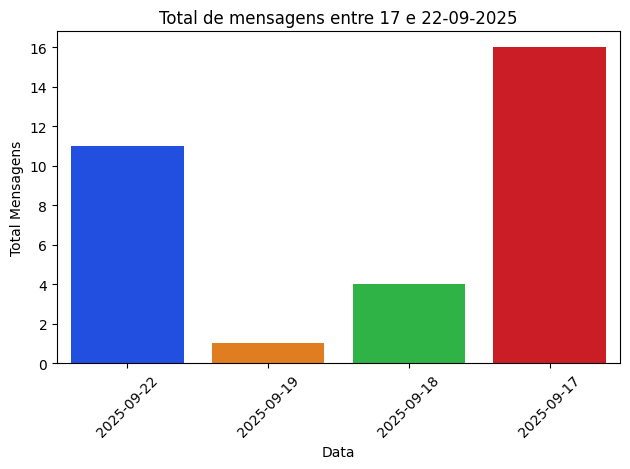

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

grafico = sns.barplot(
    data=total_mensagens_dia,
    y="qtd_mensagens",
    x="data_mensagem",
    palette="bright")

grafico.set(
    title='Total de mensagens entre 17 e 22-09-2025',
    ylabel='Total Mensagens',
    xlabel='Data')

plt.xticks(rotation=45)  # opcional: gira os rótulos do eixo X
plt.tight_layout()
plt.show()

## Total de mensagens por usuário por dia.

```sql
SELECT
  user_id AS id_usuario,
  user_first_name AS usuario,
  context_date AS data_mensagem,
  count(1) AS "qtde_mensagens"
FROM "telegram_messages"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

<img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/mensagens_usuario_por_dia.png" width="600"/>

In [7]:
import pandas as pd

mensagens_user_dia = pd.read_csv('https://raw.githubusercontent.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/main/arquivos/mensagens_usuario_por_dia.csv')
mensagens_user_dia

,id_usuario,usuario,data_mensagem,qtde_mensagens
0,8401255940,Taíta,2025-09-22,9
1,8084189022,Lincon,2025-09-22,2
2,8084189022,Lincon,2025-09-19,1
3,8084189022,Lincon,2025-09-18,2
4,8401255940,Taíta,2025-09-18,2
5,8401255940,Taíta,2025-09-17,16


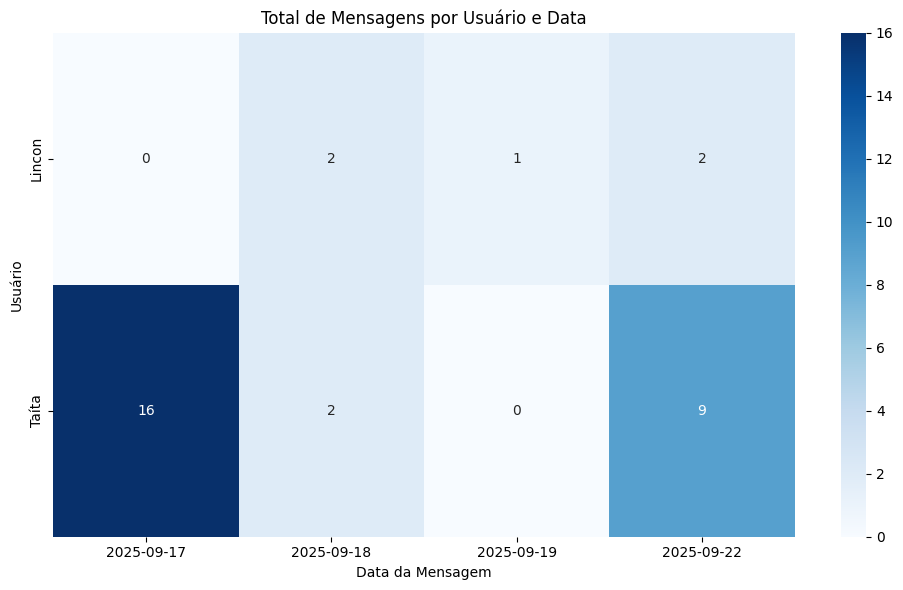

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

user_dia = mensagens_user_dia.pivot_table(index='usuario', columns='data_mensagem', values='qtde_mensagens', fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(user_dia, annot=True, cmap='Blues', fmt='.0f')
plt.title('Total de Mensagens por Usuário e Data')
plt.xlabel('Data da Mensagem')
plt.ylabel('Usuário')
plt.tight_layout()
plt.show()

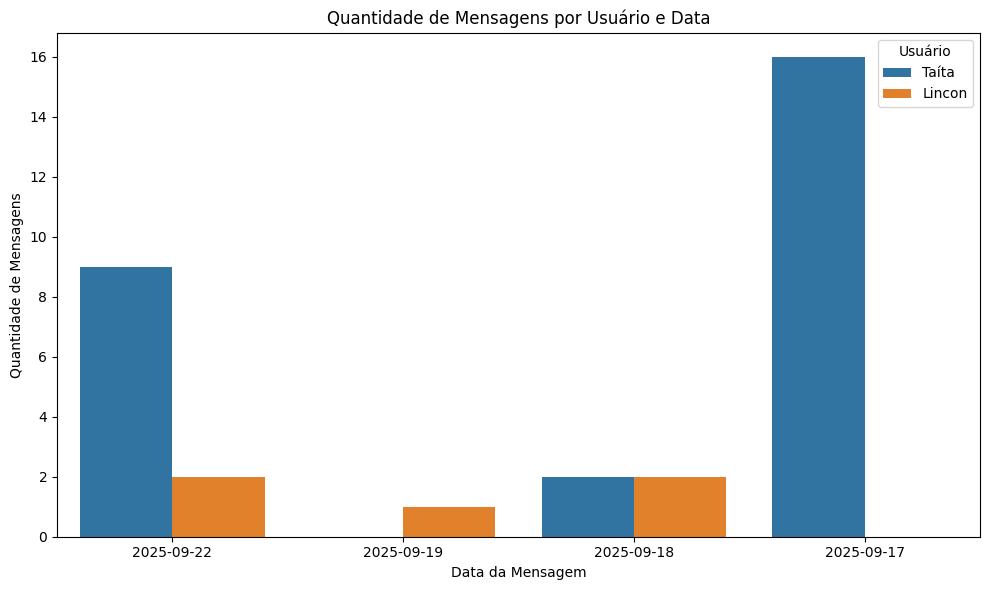

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=mensagens_user_dia, x='data_mensagem', y='qtde_mensagens', hue='usuario')
plt.title('Quantidade de Mensagens por Usuário e Data')
plt.xlabel('Data da Mensagem')
plt.ylabel('Quantidade de Mensagens')
plt.legend(title='Usuário')
plt.tight_layout()
plt.show()


## Média do tamanho das mensagens por usuário por dia.

```sql
SELECT
  user_id AS id_usuario,
  user_first_name AS usuario,
  context_date AS data_mensagem,
  CAST(AVG(length(text)) AS INT) AS "tamanho_mensagem"
FROM "telegram_messages"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

<img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/tamanho_mensagem_usuario_dia.png" width="600"/>

## Quantidade de mensagens por hora por dia da semana por número da semana.

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram_messages"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS horas_do_dia,
        EXTRACT(dow FROM parsed_date) AS dia_da_semana,
        EXTRACT(week FROM parsed_date) AS semana_do_ano
    FROM parsed_date_cte
)
SELECT
    horas_do_dia,
    dia_da_semana,
    semana_do_ano,
    count(1) AS "qtde_mensagens"
FROM hour_week_cte
GROUP BY
    horas_do_dia,
    dia_da_semana,
    semana_do_ano
ORDER BY
    semana_do_ano,
    dia_da_semana
```

<img src="https://github.com/TatyBR/Projeto_Pipeline_de_Dados_do_Telegram/raw/main/imagens/total_mensagens_hora_semana.png" width="600"/>